### EKE anomaly at the 500 m slice and final correlations tests
### - the anomaly figure with climatology added
### - correlations between ekman in the trough and the pstream slope area. 
### - the two time series to add on the slope figure. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'



import cosima_cookbook as cc

from cosima_cookbook import distributed as ccd

import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
import xarray as xr
import cmocean.cm as cmocean
import matplotlib.ticker as ticker
from dask.distributed import Client

import cartopy.crs as ccrs
import cartopy.feature as feature

land_50m = feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.2)

Start up a dask cluster.

In [2]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33077/status,
Dashboard: /proxy/33077/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33965,Workers: 7
Dashboard: /proxy/33077/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:33425,Total threads: 4
Dashboard: /proxy/37047/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:46477,


Create a database session and select an experiment. Here we choose an experiment which has daily velocities saved for the Southern Ocean.

In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt = '01deg_jra55v13_ryf9091'
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
iaf_cycle = '01deg_jra55v140_iaf'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

In [4]:
lat_slice  = slice(-67, -64)
lon_slice  = slice(-255, -246)

depth_slice = 500
u = cc.querying.getvar(iaf_cycle,'u',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 daily').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice).sel(st_ocean=depth_slice,method = 'nearest')

v = cc.querying.getvar(iaf_cycle,'v',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 daily').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice).sel(st_ocean=depth_slice,method = 'nearest')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

In [5]:
u_mean = u.mean('time')
v_mean = v.mean('time')

In [6]:
u_transient = u - u_mean
v_transient = v - v_mean

In [7]:
dz=1
EKE = (0.5*(u_transient**2 + v_transient**2)*dz)

In [8]:
%%time
EKE = EKE.compute()

CPU times: user 3min 48s, sys: 22.5 s, total: 4min 10s
Wall time: 7min 13s


In [9]:
EKE_mth = EKE.resample(time='1M').mean(dim='time')

In [10]:
# calculate monthly climatology
climatology = EKE_mth.groupby('time.month').mean('time')

# remove seasonal signal
EKE_mth_seasonal_removed = (EKE_mth - climatology)

In [11]:
# select a single month and drop the 'month' dimension
EKE_mth_seasonal_removed = EKE_mth_seasonal_removed.isel(month=0).drop('month')

In [12]:
## I have a bit of an issue with the peaks, as they were calculated for the full period of IAF3, but IAF1 only has data from 1987-01-31
## the new files have 384 indexes on time after they get resampled, so I will just remove the first indexes of the bt and top after I load them. 
EKE_mth_seasonal_removed.time

<xarray.DataArray 'time' (time: 384)> Size: 3kB
array(['1987-01-31T00:00:00.000000000', '1987-02-28T00:00:00.000000000',
       '1987-03-31T00:00:00.000000000', ..., '2018-10-31T00:00:00.000000000',
       '2018-11-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    st_ocean  float64 8B 517.6
  * time      (time) datetime64[ns] 3kB 1987-01-31 1987-02-28 ... 2018-12-31

#### Calculate EKE Anomalies

### Calculate the rolling mean 

In [13]:
EKE_500_roll = EKE_mth_seasonal_removed.rolling(time=12, center=True).mean()
EKE_500_roll2 = EKE_mth.rolling(time=12, center=True).mean()

### loading indexes previously calculated by "Selecting_peak_low_years" code stored in /Figures/New_codes_CFD

In [14]:
outpath = '/g/data/v45/ns3783/top_index.nc'
profile_data = xr.open_dataset(outpath)
top_id = profile_data.top_id

In [15]:
outpath = '/g/data/v45/ns3783/bottom_index.nc'
profile_data = xr.open_dataset(outpath)
bt_id = profile_data.bt_id

In [16]:
## I am having a little trouble with this because the indexes were calculated for the IAF3 which has data since the 1958 while the IAF1, which was used to calculate the EKE because it has daily speed 
## in z doesn't. So I have to look for the indexes on th etop and bt arrays and just use the dates after 1987.
#bt_id.time.values
#top_id.time.values

In [17]:
# Convert bt_id to a NumPy array
bt_id_array = bt_id.time.values

# Specify the target timestamp as a string
target_timestamp = '1987-01-16T12:00:00.000000000'

# Find the index where bt_id is equal to the target timestamp
index = np.where(bt_id_array == np.datetime64(target_timestamp))[0]

# Print the result
print(index)

[84]


In [18]:
#732-384=348 (I have test this and it is ok as python indexing starts in 0).
bt_id_short = bt_id[84:]
bt_id_short = bt_id_short-348

In [19]:
# Convert bt_id to a NumPy array
top_id_array = top_id.time.values

# Specify the target timestamp as a string
target_timestamp =  '1989-07-16T12:00:00.000000000'

# Find the index where bt_id is equal to the target timestamp
index = np.where(top_id_array == np.datetime64(target_timestamp))[0]

# Print the result
print(index)

[37]


In [20]:
#732-384=348 (I have test this and it is ok as python indexing starts in 0).
top_id_short = top_id[37:]
top_id_short = top_id_short-348

### creating the averages for peaks and lows

In [21]:
#full mean, for those without climatology applied
EKE_int_avg = EKE_500_roll.mean('time')
EKE_int_avg = EKE_int_avg.load()

#mean of all high peaks together
EKE_high_avg=EKE_500_roll[top_id_short.values].mean('time')
EKE_high_avg = EKE_high_avg.load()


#mean of all low peaks together
EKE_low_avg = EKE_500_roll[bt_id_short.values].mean('time')
EKE_low_avg = EKE_low_avg.load()

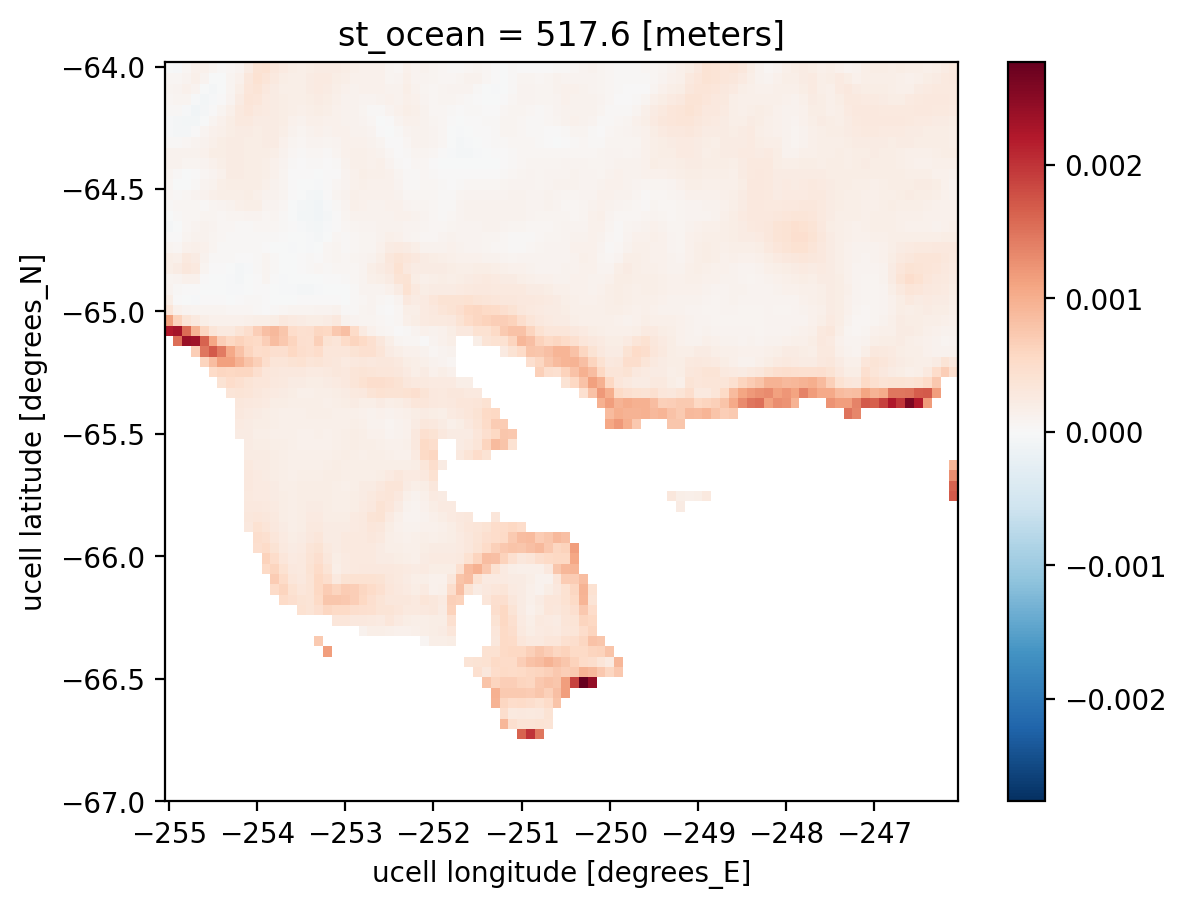

In [22]:
EKE_int_avg.plot()

In [23]:
#full mean, for those without climatology applied
EKE_int_avg2 = EKE_500_roll2.mean('time')
EKE_int_avg2 = EKE_int_avg2.load()

#mean of all high peaks together
EKE_high_avg2=EKE_500_roll2[top_id_short.values].mean('time')
EKE_high_avg2 = EKE_high_avg2.load()


#mean of all low peaks together
EKE_low_avg2 = EKE_500_roll2[bt_id_short.values].mean('time')
EKE_low_avg2 = EKE_low_avg2.load()

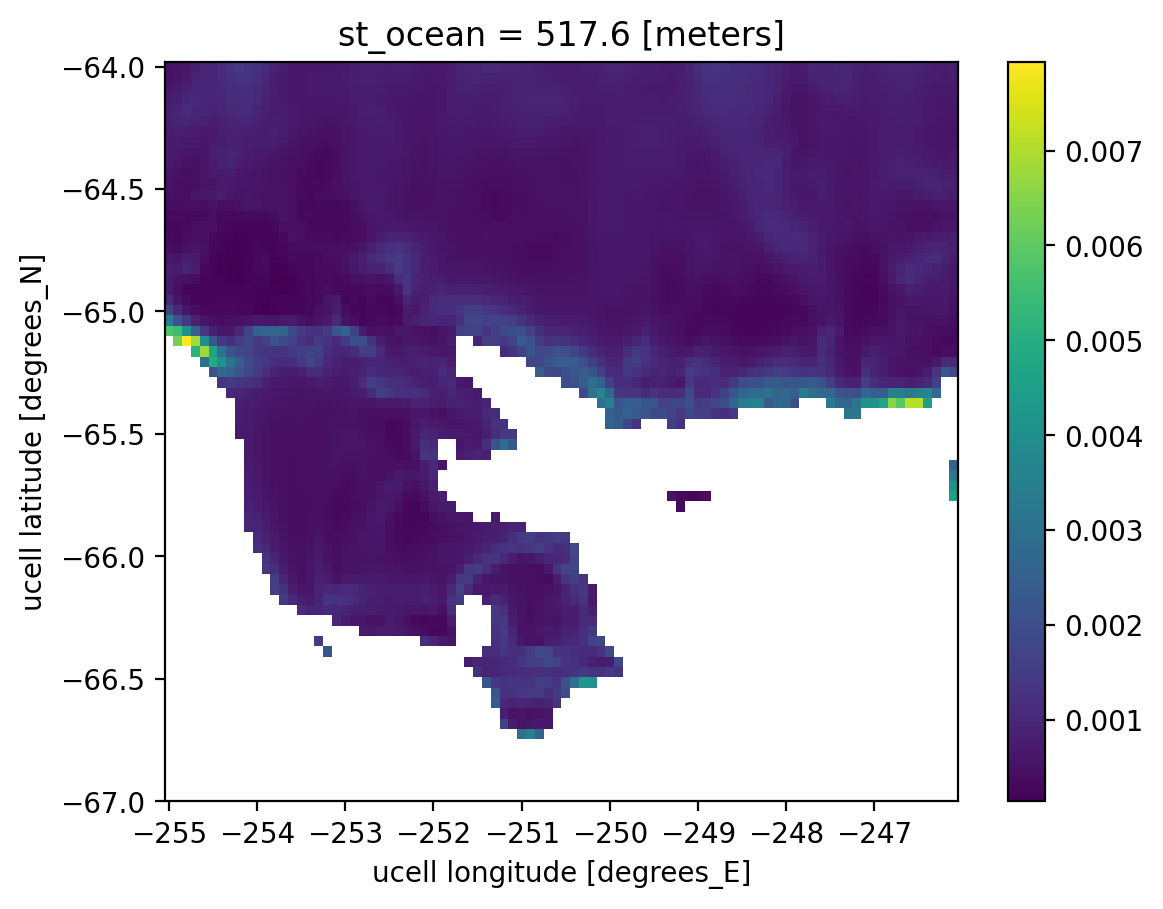

In [24]:
EKE_int_avg2.plot()

## PLOT COMPOSITES FOR EKE ANOMALIES 
#### - CLIMATOLOGY ISN'T REMOVED TO AVOID NEGATIVE VALUES. ONLY ROLLING MEAN APPLIED

In [52]:
# cut the data BOX 1
lon_slice  = slice(-255, -240)
lat_slice  = slice(-67, -63)

# topography data:
hu = cc.querying.getvar(iaf_cycle3,'hu' , master_session,n=1)
hu = hu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
land_mask = np.squeeze(hu.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)



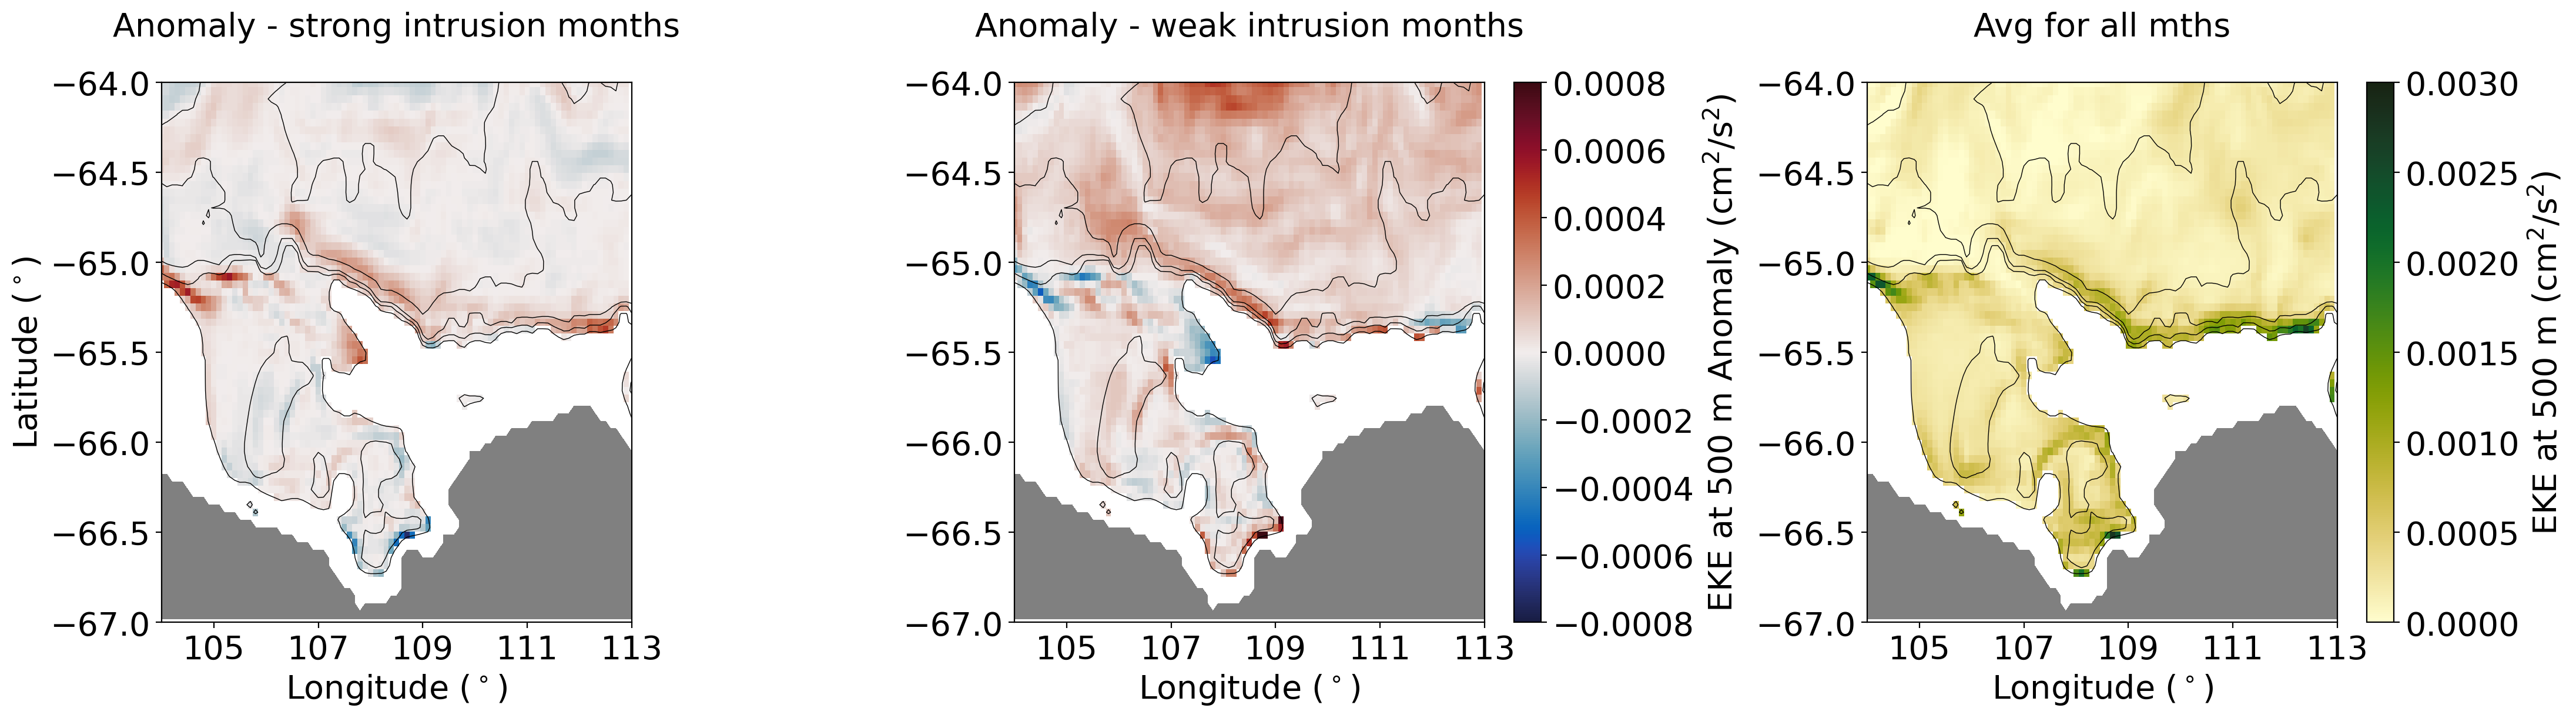

In [62]:
### test new values
fontsize=20

#for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

t_high = EKE_high_avg-EKE_int_avg;
t_low = EKE_low_avg-EKE_int_avg;
ax0=plt.subplot(431) 
pc = plt.pcolormesh(t_high.xu_ocean,t_high.yu_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-0.0008,vmax=0.0008)
plt.title('Anomaly - strong intrusion months\n',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 700, 1000, 2000, 3000], colors='k', linewidths=0.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
# plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
#this removes colorbar whilst maintaing figure size
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticks([-254, -252, -250, -248, -246]) 
ax0.set_xticklabels([-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

ax0=plt.subplot(4,3,2)      
pc = plt.pcolormesh(t_low.xu_ocean,t_low.yu_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-0.0008,vmax=0.0008)
plt.title('Anomaly - weak intrusion months\n',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 700, 1000, 2000, 3000], colors='k', linewidths=0.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
# plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'EKE at 500 m Anomaly (cm$^{2}$/s$^{2}$)', fontsize = fontsize,labelpad=5)
ax0.set_xticks([-254, -252, -250, -248, -246]) 
ax0.set_xticklabels([-254+359,-252+359,-250+359,-248+359,-246+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
cbar.ax.tick_params(labelsize=20)

ax0=plt.subplot(4,3,3)    
pc = plt.pcolormesh(EKE_int_avg.xu_ocean,EKE_int_avg.yu_ocean,
                        EKE_int_avg, cmap = cmocean.speed, 
                        vmin=0.,vmax=0.003)
plt.title('Avg for all mths\n',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 700, 1000, 2000, 3000], colors='k', linewidths=0.5)

# plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'EKE at 500 m (cm$^{2}$/s$^{2}$)', fontsize = 20,labelpad=5)
ax0.set_xticks([-254, -252, -250, -248, -246]) 
ax0.set_xticklabels([-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
cbar.ax.tick_params(labelsize=20)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
filestr = figdir+'/FigSI_eke_anomaly_clim.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

## no titles in case it doesnt matter for size


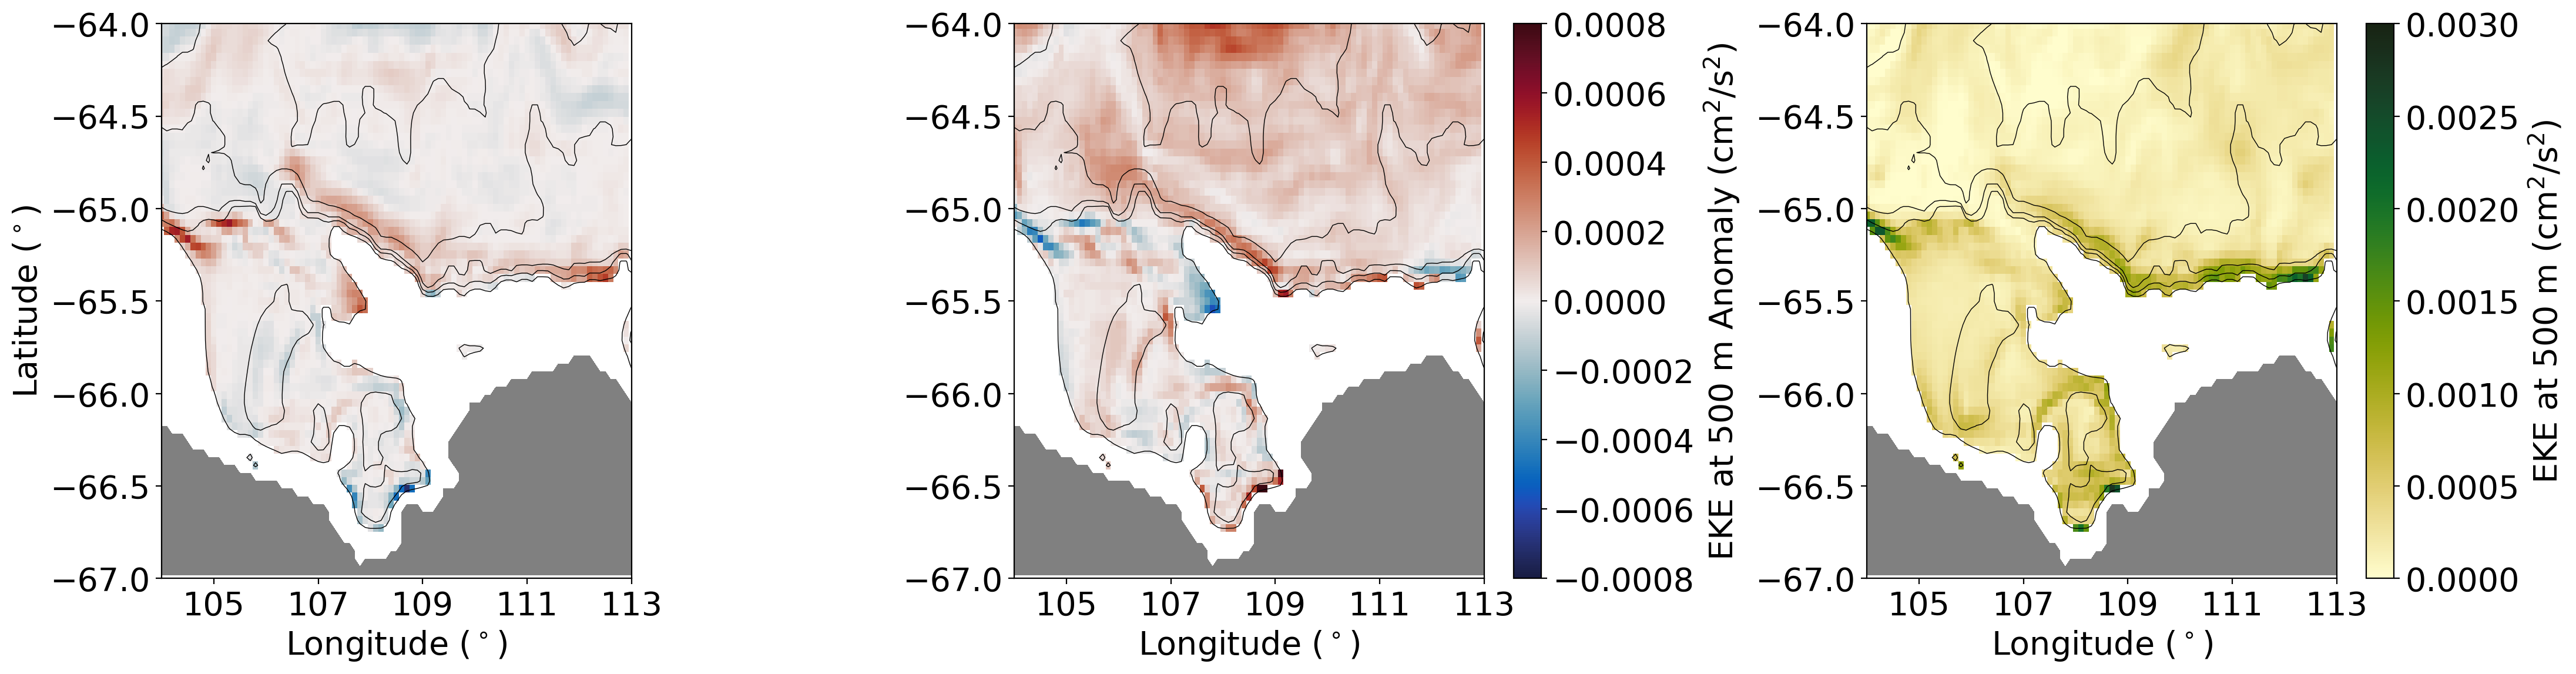

In [63]:
### test new values
fontsize=20

#for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

t_high = EKE_high_avg-EKE_int_avg;
t_low = EKE_low_avg-EKE_int_avg;
ax0=plt.subplot(431) 
pc = plt.pcolormesh(t_high.xu_ocean,t_high.yu_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-0.0008,vmax=0.0008)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for peak temp mths',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 700, 1000, 2000, 3000], colors='k', linewidths=0.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
# plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
#this removes colorbar whilst maintaing figure size
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticks([-254, -252, -250, -248, -246]) 
ax0.set_xticklabels([-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

ax0=plt.subplot(4,3,2)      
pc = plt.pcolormesh(t_low.xu_ocean,t_low.yu_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-0.0008,vmax=0.0008)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for low temp mths',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 700, 1000, 2000, 3000], colors='k', linewidths=0.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
# plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'EKE at 500 m Anomaly (cm$^{2}$/s$^{2}$)', fontsize = fontsize,labelpad=5)
ax0.set_xticks([-254, -252, -250, -248, -246]) 
ax0.set_xticklabels([-254+359,-252+359,-250+359,-248+359,-246+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
cbar.ax.tick_params(labelsize=20)

ax0=plt.subplot(4,3,3)    
pc = plt.pcolormesh(EKE_int_avg.xu_ocean,EKE_int_avg.yu_ocean,
                        EKE_int_avg, cmap = cmocean.speed, 
                        vmin=0.,vmax=0.003)
#plt.title('Avg for all mths',fontsize=fontsize)
        #plot contours
plt.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 700, 1000, 2000, 3000], colors='k', linewidths=0.5)

# plot the land:
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'EKE at 500 m (cm$^{2}$/s$^{2}$)', fontsize = 20,labelpad=5)
ax0.set_xticks([-254, -252, -250, -248, -246]) 
ax0.set_xticklabels([-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
cbar.ax.tick_params(labelsize=20)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
filestr = figdir+'/FigSI_eke_anomaly_clim_no_title.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

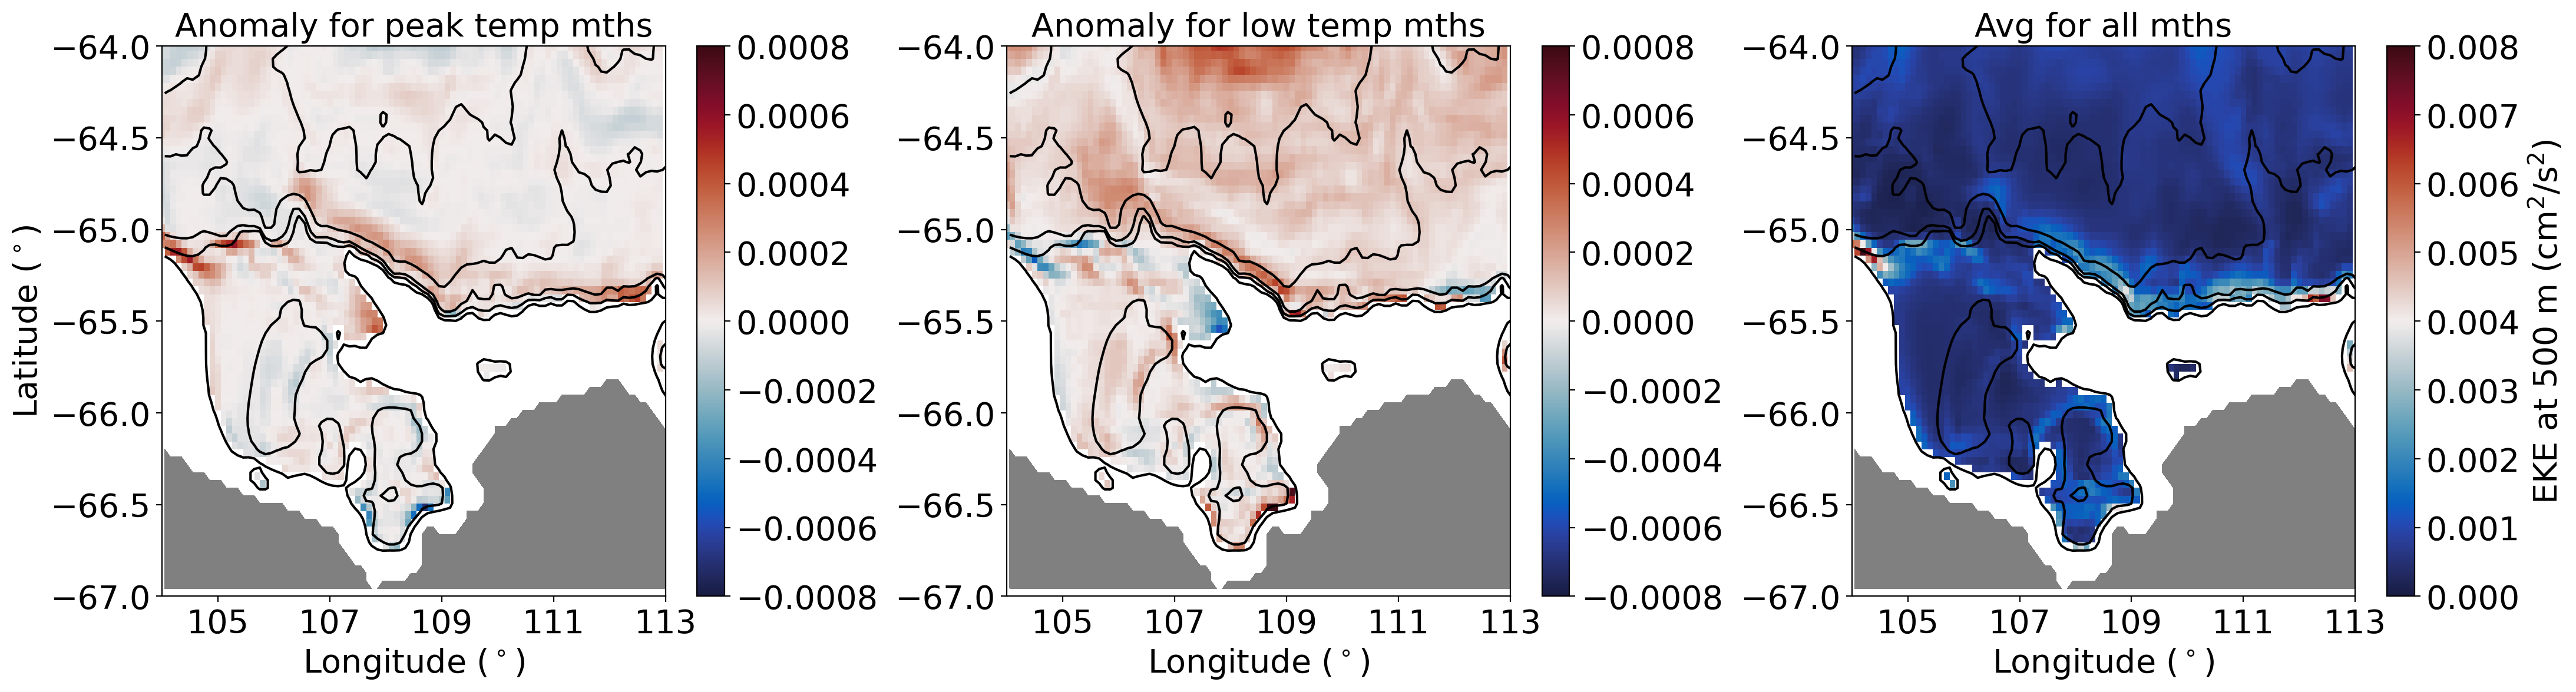

In [35]:
### test new values
fontsize=20

#for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

t_high = EKE_high_avg2-EKE_int_avg2;
t_low = EKE_low_avg2-EKE_int_avg2;
ax0=plt.subplot(431) 
pc = plt.pcolormesh(t_high.xu_ocean,t_high.yu_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-0.0008,vmax=0.0008)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly - strong intrusion mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
# plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_label(r'EKE (cm$^{2}$/s$^{2}$)', fontsize = fontsize,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,2)      
pc = plt.pcolormesh(t_low.xu_ocean,t_low.yu_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-0.0008,vmax=0.0008)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly - weak intrusion mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_label(r'EKE (cm$^{2}$/s$^{2}$)', fontsize = fontsize,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,3)    
pc = plt.pcolormesh(EKE_int_avg2.xu_ocean,EKE_int_avg2.yu_ocean,
                        EKE_int_avg2, cmap = cmocean.balance, 
                        vmin=0,vmax=0.008)
plt.title('Avg for all mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)

##TO INCLUDE THE ASC TRANSECT AND TBOX POSITIONS
#plt.plot([-252.7,-252.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=5)
#plt.plot([-251.7,-251.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=5)
#plt.plot([-252.7,-251.7],[-65.1, -65.1],color='blueviolet',linestyle='--',linewidth=5)
#plt.plot([-252.7,-251.7],[-65.35, -65.35],color='blueviolet',linestyle='--',linewidth=5)
#
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='blueviolet',linestyle='--',linewidth=4)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'EKE at 500 m (cm$^{2}$/s$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
filestr = figdir+'/FigSI_eke_anomaly_just_roll.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')